In [88]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------
# 1. Load Both Datasets
# ---------------------------------------------------------------
df1 = pd.read_csv("../datasets/water_potability.csv")
df2 = pd.read_csv("../datasets/waterQuality1.csv")

df1.columns = df1.columns.str.lower().str.strip()
df2.columns = df2.columns.str.lower().str.strip()

# ---------------------------------------------------------------
# 2. Forced fuzzy merge map
# ---------------------------------------------------------------
forced_map = {
    "chloramines": "chloramine",
    "chloramine": "chloramine",
    "flouride": "fluoride",
    "fluoride": "fluoride",
    "bacteriological": "bacteria",
    "bacteria": "bacteria",
    "virus": "viruses",
    "viruses": "viruses"
}

df1 = df1.rename(columns=forced_map)
df2 = df2.rename(columns=forced_map)

# ---------------------------------------------------------------
# 3. Replace Excel/CSV errors with NaN
# ---------------------------------------------------------------
excel_errors = ["#NUM!", "#DIV/0!", "#REF!", "#VALUE!", "#NAME?", "#NULL!", "#N/A"]
df2 = df2.replace(excel_errors, np.nan)

for col in df2.columns:
    df2[col] = pd.to_numeric(df2[col], errors="coerce")

# ---------------------------------------------------------------
# 4. Standardize labels
# ---------------------------------------------------------------
if "potability" in df1.columns:
    df1["is_safe"] = df1["potability"]
    df1 = df1.drop(columns=["potability"])

# ------------------------------------------
# 5. Build union of all columns
# ------------------------------------------
# Build union of columns
all_cols = sorted(list(set(df1.columns).union(set(df2.columns))))

# Add missing columns without overwriting existing ones
for col in all_cols:
    if col not in df1.columns:
        df1[col] = np.nan
    if col not in df2.columns:
        df2[col] = np.nan

# Reorder
df1 = df1[all_cols]
df2 = df2[all_cols]

# Concatenate and Fill remaining NaN with 0
df = pd.concat([df1, df2], ignore_index=True)
df = df.fillna(0)

# ---------------------------------------------------------------
# 8. Split features + target
# ---------------------------------------------------------------
# Notes:
# - We must separate INPUTS (X) and OUTPUT (y) before training a model.
# - X = features → the model uses these columns to make predictions.
# - y = target → the correct label the model should learn to predict.
#
# Why drop "is_safe" from X?
# - Because "is_safe" is the ANSWER LABEL (0 or 1).
# - If we keep it inside X, the model will see the correct answer during training.
#   This causes DATA LEAKAGE, meaning:
#       * The model will learn to cheat by directly reading "is_safe".
#       * Accuracy becomes unrealistically high.
#       * The model will FAIL on real, unseen data.
# - In real-world use, we will NOT know "is_safe" beforehand — that is what the model must guess.
#
# Therefore:
# - X must contain ONLY water-quality measurements.
# - y must contain ONLY the "is_safe" label.

X = df.drop(columns=["is_safe"])
y = df["is_safe"]

print("Merged Data (100 data):", df.shape)
print(df.head(50).to_string())

Merged Data (100 data): (11275, 29)
    aluminium  ammonia  arsenic  bacteria  barium  cadmium  chloramine  chromium  conductivity  copper  fluoride    hardness  is_safe  lead  mercury  nitrates  nitrites  organic_carbon  perchlorate         ph  radium  selenium  silver        solids     sulfate  trihalomethanes  turbidity  uranium  viruses
0         0.0      0.0      0.0       0.0     0.0      0.0    7.300212       0.0    564.308654     0.0       0.0  204.890455      0.0   0.0      0.0       0.0       0.0       10.379783          0.0   0.000000     0.0       0.0     0.0  20791.318981  368.516441        86.990970   2.963135      0.0      0.0
1         0.0      0.0      0.0       0.0     0.0      0.0    6.635246       0.0    592.885359     0.0       0.0  129.422921      0.0   0.0      0.0       0.0       0.0       15.180013          0.0   3.716080     0.0       0.0     0.0  18630.057858    0.000000        56.329076   4.500656      0.0      0.0
2         0.0      0.0      0.0       0.0  

In [89]:
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------------
# 9. Train/test split
# ---------------------------------------------------------------
# Notes:
# - Splits dataset into training and testing sets
# - X_train, y_train → used to train models
# - X_test, y_test → used to evaluate model performance
# - test_size=0.25 → 25% of data is reserved for testing
# - random_state=42 → ensures reproducible split (same split every run)
# - Formula (conceptually):
#       Training set: 75% of samples
#       Test set: 25% of samples
#       X_train, X_test, y_train, y_test = train_test_split(X, y, ...)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [90]:
# ---------------------------------------------------------------
# 5. Random Forest Classifier
# ---------------------------------------------------------------
# Notes:
# - Random Forest is an ensemble method of decision trees.
# - Each tree is trained on a random bootstrap sample of the training data.
# - At each node, a random subset of features is used to find the best split.
# - Splitting criteria: Gini Impurity or Entropy
#   - Gini Impurity: G = 1 - sum(p_i^2), where p_i = proportion of class i in node
#   - Entropy: H = -sum(p_i * log2(p_i))
# - Predictions: majority vote of all trees
# - Parameters in this code:
#   - n_estimators=300 → number of trees
#   - max_depth=None → trees grow fully until leaves are pure
#   - random_state=42 → ensures reproducible results
# - rf.fit(X_train, y_train) → trains the forest
# - rf.predict(X_test) → predicts labels for test data
# - accuracy_score & classification_report → evaluate performance

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("===========================================")
print("Random Forest Results")
print("===========================================")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

Random Forest Results
Accuracy: 0.8659098971266407

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      2246
         1.0       0.80      0.45      0.58       573

    accuracy                           0.87      2819
   macro avg       0.84      0.71      0.75      2819
weighted avg       0.86      0.87      0.85      2819



In [91]:
# ---------------------------------------------------------------
# 6. Logistic Regression Classifier
# ---------------------------------------------------------------
# Notes:
# - Logistic Regression is a linear model for classification.
# - Uses the sigmoid function to predict probabilities:
#       p(y=1|x) = 1 / (1 + exp(- (w^T * x + b)))
# - Predict class 1 if probability > 0.5, else class 0
# - Pipeline is used to ensure proper preprocessing:
#   1. StandardScaler → scales features to mean=0, std=1
#   2. LogisticRegression → fits model on scaled features
# - Parameters in this code:
#   - max_iter=20000 → allows more iterations for solver to converge
#   - class_weight="balanced" → penalizes majority class in imbalanced datasets
#   - solver="lbfgs" → optimization algorithm
# - logreg_pipeline.fit(X_train, y_train) → trains the pipeline
# - logreg_pipeline.predict(X_test) → predicts labels for test data
# - accuracy_score & classification_report → evaluate performance

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Pipeline: scale → logistic regression
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=20000,          # way more iterations
        class_weight="balanced", # penalize majority class
        solver="lbfgs"
    ))
])

logreg_pipeline.fit(X_train, y_train)

logreg_pred = logreg_pipeline.predict(X_test)

print("===========================================")
print("Logistic Regression Results")
print("===========================================")
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))


Logistic Regression Results
Accuracy: 0.7289819084781838

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.70      0.80      2246
         1.0       0.42      0.84      0.56       573

    accuracy                           0.73      2819
   macro avg       0.68      0.77      0.68      2819
weighted avg       0.84      0.73      0.75      2819



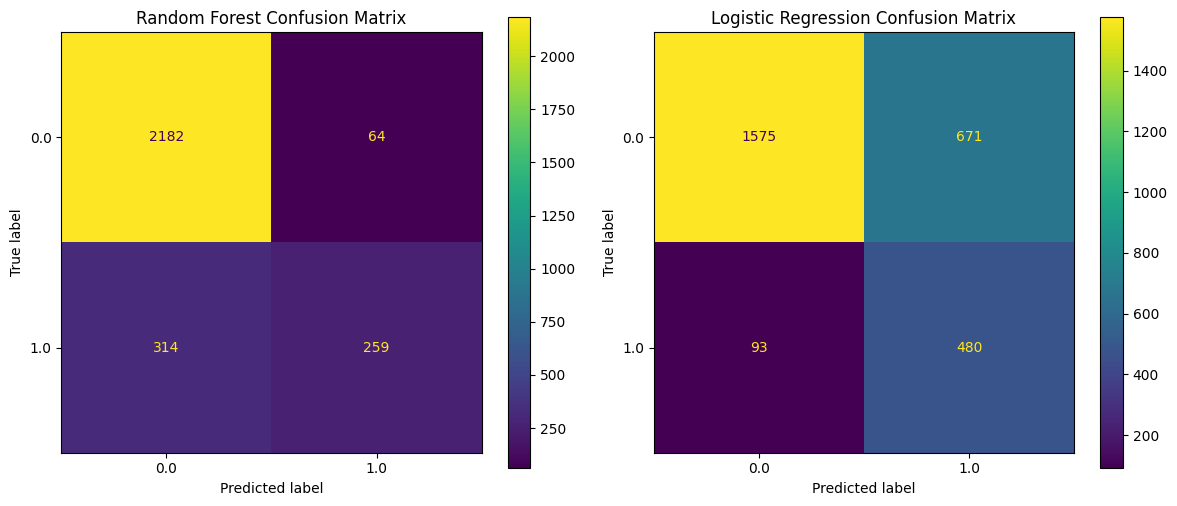

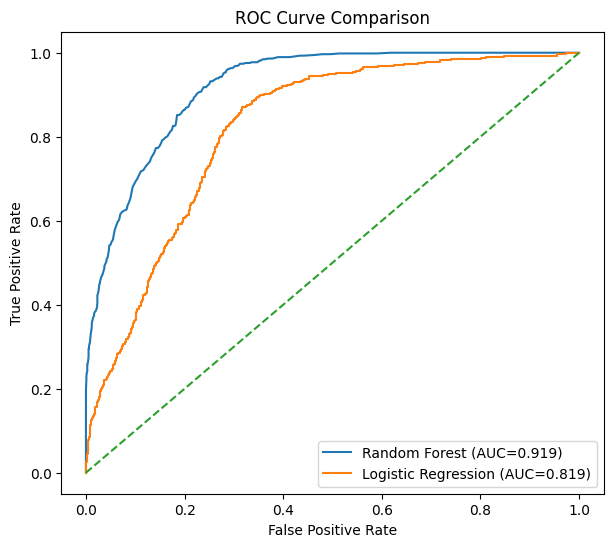

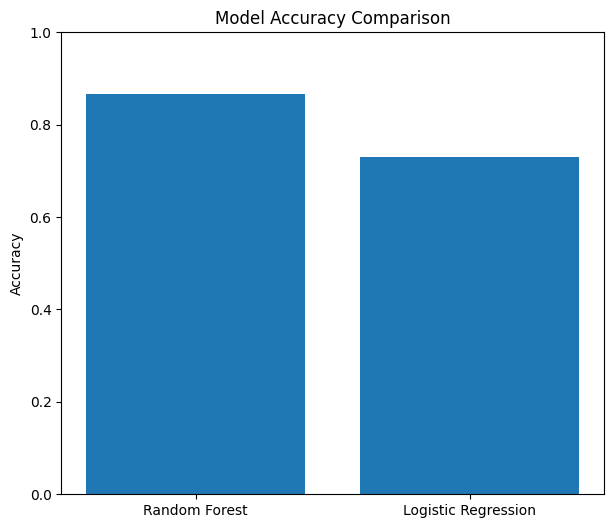

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# ---------------------------------
# CONFUSION MATRICES
# ---------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_test, logreg_pred, ax=ax[1])
ax[1].set_title("Logistic Regression Confusion Matrix")

plt.tight_layout()
plt.show()

# ---------------------------------
# ROC CURVE COMPARISON
# ---------------------------------
rf_probs = rf.predict_proba(X_test)[:, 1]
logreg_probs = logreg_pipeline.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
log_fpr, log_tpr, _ = roc_curve(y_test, logreg_probs)

rf_auc = auc(rf_fpr, rf_tpr)
log_auc = auc(log_fpr, log_tpr)

plt.figure(figsize=(7, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC={rf_auc:.3f})")
plt.plot(log_fpr, log_tpr, label=f"Logistic Regression (AUC={log_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# ---------------------------------
# ACCURACY BAR CHART
# ---------------------------------
plt.figure(figsize=(7, 6))
plt.bar(["Random Forest", "Logistic Regression"], 
        [accuracy_score(y_test, rf_pred), accuracy_score(y_test, logreg_pred)])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
